# Assignment 3: Analyze Dow Jones 30 Stocks Expected Returns and Obtain the Efficent Frontier
Group 12: Congci Hao

<b> Objectives: </b>
1. Analyze the expected returns of 30 companies in the Dow Jones list by applying Capital Asset Pricing Model (CAPM)
2. Compare the expected returns and realized returns in the stock market over the past 5 years
3. Interpret and visualize the difference based on the time-series visualizations and numerical calculations
4. Construct and visualize the efficient frontier of the portfolio of top 3 performers from the Dow Jones list
5. Perform regression analysis on the minimum variance portfolio against the S&P 500 index
6. Conclude insights from the previous analysis

## Section I: Analyze the Expected Return 
### Retrieve the list of Dow Jones 30 companies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas_datareader import data as wb

from scipy import stats
import statsmodels.api as sm 

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set the maximum number of outputs 
pd.options.display.max_rows = 20

In [3]:
import re, requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
req = requests.get(url)
html = req.text

#content = re.findall('<tbody>.+?</tbody>',html,re.DOTALL)
soup = BeautifulSoup(html, 'html.parser')

records = []
tt = ()
table = soup.find('table', attrs={'class':"wikitable sortable"})
entries = table.find_all('tr')
for entry in entries:

    columns = entry.find_all('td')
    
    if len (columns)>5 :

        name = columns[0].get_text().strip('\n')
        ticker = columns[2].get_text().strip('\n')
        industry = columns[3].get_text().strip('\n')

        tt = (name,ticker,industry)

    records.append(tt)
#Need to filter an empty list from the source code
records = list(filter(None, records))

print(records)
len(records)

[('3M', 'MMM', 'Conglomerate'), ('American Express', 'AXP', 'Financial services'), ('Apple', 'AAPL', 'Information technologies'), ('Boeing', 'BA', 'Aerospace and defense'), ('Caterpillar', 'CAT', 'Construction and mining equipment'), ('Chevron', 'CVX', 'Oil & gas'), ('Cisco Systems', 'CSCO', 'Information technologies'), ('Coca-Cola', 'KO', 'Food'), ('Dow Inc.', 'DOW', 'Chemical industry'), ('ExxonMobil', 'XOM', 'Oil & gas'), ('Goldman Sachs', 'GS', 'Financial services'), ('The Home Depot', 'HD', 'Retail'), ('IBM', 'IBM', 'Information technologies'), ('Intel', 'INTC', 'Information technologies'), ('Johnson & Johnson', 'JNJ', 'Pharmaceuticals'), ('JPMorgan Chase', 'JPM', 'Financial services'), ("McDonald's", 'MCD', 'Food'), ('Merck & Company', 'MRK', 'Pharmaceuticals'), ('Microsoft', 'MSFT', 'Information technologies'), ('Nike', 'NKE', 'Apparel'), ('Pfizer', 'PFE', 'Pharmaceuticals'), ('Procter & Gamble', 'PG', 'Consumer goods'), ('Travelers', 'TRV', 'Financial services'), ('UnitedHealth

30

In [4]:
# Transform the list of tuples in the varaible records into a pandas dataframe 
df = pd.DataFrame(records)

# Set column names 
df.columns=['Company','Ticker','Industry']

### Construct the dataframe of stock prices for 30 companies in the Dow Jones list and calculate the log returns 

In [5]:
tickers = list(df['Ticker'])
tickers.append('^GSPC')

end = datetime.today()
start = datetime(end.year-5,end.month,end.day)

sec_data = pd.DataFrame()
for t in tickers:
    sec_data[t] = wb.DataReader(t,data_source='yahoo',start=start,end=end)['Adj Close']

sec_data.tail()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DOW,XOM,...,PG,TRV,UNH,UTX,VZ,V,WMT,WBA,DIS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-30,177.630005,126.470001,208.779999,347.459991,132.949997,124.339996,56.470001,53.720001,48.400002,75.349998,...,120.410004,147.619995,254.929993,135.300003,56.630001,181.529999,112.059998,55.400002,144.929993,3013.179932
2019-07-31,174.720001,124.370003,213.039993,341.179993,131.669998,123.110001,55.400002,52.630001,48.439999,74.360001,...,118.040001,146.619995,249.009995,133.600006,55.270000,178.000000,110.379997,54.490002,143.009995,2980.379883
2019-08-01,173.360001,124.089996,208.429993,334.290009,126.790001,120.739998,55.389999,52.029999,46.849998,72.459999,...,116.730003,145.779999,249.250000,131.839996,55.259998,179.169998,109.379997,54.070000,141.850006,2953.560059
2019-08-02,170.550003,124.309998,204.020004,339.559998,124.540001,120.730003,53.250000,52.330002,45.599998,71.750000,...,116.440002,146.919998,250.050003,130.809998,55.590000,177.419998,109.400002,53.680000,141.710007,2932.050049
2019-08-05,164.710007,120.720001,193.339996,331.059998,121.650002,118.739998,51.369999,51.650002,44.770000,70.279999,...,113.080002,143.929993,245.059998,125.750000,55.220001,168.860001,105.820000,51.869999,138.300003,2844.739990


In [6]:
#Substitute the missing values with the average of that company's stock prices
sec_data = sec_data.apply(lambda x: x.fillna(x.mean()),axis=0)

In [7]:
# pct_change(obtains simple returns from a given dataset
log_returns = np.log(1 + sec_data.pct_change())

In [8]:
#Construct the stock returns without SP500 
sec_returns = log_returns.iloc[:,:-1]

### Calculate annual realized returns, variance, volatility measures, and betas and build new columns into the company list

In [9]:
# Calculate the annual return based on the mean and 250 trading days each year
# Add to the master data frame
df['Realized_Return'] = list(sec_returns.mean()*250)

In [10]:
# Calculate the volatility which is the standard deviation 
# Add to the master data frame
df['Volatility'] = list(sec_returns.std()*250**0.5)

In [11]:
# Compute the variance and compare the covariance with SP500
cov = log_returns.cov()*250

In [12]:
# Compute the corrleation and compare with SP500
corr = log_returns.corr()

<b> Beta Formula: </b>
### $$ 
\beta_{pg} = \frac{\sigma_{pg,m}}{\sigma_{m}^2}
$$

In [13]:
# Calculate stock betas basd on the formula above

betas=[]
for num in range(30):
    cov_with_market = cov.iloc[30,num]
    market_var = log_returns['^GSPC'].var()*250
    beta = cov_with_market / market_var
    betas.append(beta)
betas

[0.9719132995483901,
 0.9608862395827076,
 1.2147063870899775,
 1.1546830301823336,
 1.322074672644883,
 1.0294388078738799,
 1.1659406773056007,
 0.5126289084434232,
 0.07333297184841239,
 0.9085957096203934,
 1.2741470825960328,
 0.9509523097027228,
 0.9465876890967895,
 1.2240867610853179,
 0.7176454343256401,
 1.171780454248977,
 0.6061135526999711,
 0.8065167801520357,
 1.3023145341312006,
 0.9882092778799154,
 0.7940559213714411,
 0.5656425598628932,
 0.7696623498431502,
 0.9423549496354022,
 0.9454647946952816,
 0.5571272285619077,
 1.1529100262374574,
 0.6220907052747042,
 0.9300595821127391,
 0.8539012457848502]

In [14]:
df['Beta']=betas

In [15]:
# Set the Ticker as the index
df = df.set_index('Ticker')

**Calculate the expected return (CAPM):**
### $$
\overline{r_{s}} = r_f + \beta_{s}(\overline{r_{m}} - r_f) 
$$

In [16]:
# We assume that the risk-free rate is 2.5% from government-issued T-bills
rf = 0.025
# Calculate the Market Preimum by subtracing the risk-free rate from the market return 
rp = log_returns['^GSPC'].mean()*250 - rf

In [17]:
# Calculate the Exptected Return by applying the CAPM forumla above
df['Expected_Return'] = df['Beta']*rf +rf

## Section II: Compare the Expected Returns with Realized Returns

In [18]:
df.describe()

,Realized_Return,Volatility,Beta,Expected_Return
count,30.000000,30.000000,30.000000,30.000000
mean,0.106401,0.200553,0.914527,0.047863
std,0.080996,0.037490,0.281185,0.007030
min,-0.036545,0.097789,0.073333,0.026833
25%,0.061055,0.180276,0.775761,0.044394
50%,0.098049,0.200162,0.946026,0.048651
75%,0.159758,0.229982,1.154240,0.053856
max,0.245425,0.265377,1.322075,0.058052


In [19]:
df = df.sort_values('Expected_Return',ascending=False)
df

,Company,Industry,Realized_Return,Volatility,Beta,Expected_Return
Ticker,,,,,,
CAT,Caterpillar,Construction and mining equipment,0.069711,0.265377,1.322075,0.058052
MSFT,Microsoft,Information technologies,0.245425,0.232590,1.302315,0.057558
GS,Goldman Sachs,Financial services,0.048459,0.234957,1.274147,0.056854
INTC,Intel,Information technologies,0.097834,0.254882,1.224087,0.055602
AAPL,Apple,Information technologies,0.158282,0.246770,1.214706,0.055368
JPM,JPMorgan Chase,Financial services,0.160250,0.208141,1.171780,0.054295
CSCO,Cisco Systems,Information technologies,0.174623,0.215651,1.165941,0.054149
BA,Boeing,Aerospace and defense,0.226515,0.245258,1.154683,0.053867
V,Visa,Financial services,0.242471,0.206075,1.152910,0.053823


***Alpha*** describe an investment strategy to beat the market or its edge, also known as "excess return" or "abnormal rate of return", which refers to the idea that markets are efficient and there is no way to systemtially earn returns.

Alpha is often used to rank actual mutual funds as well as other types of investments.

In [20]:
#Calculate Alpaha which is the difference between the exptected reutrn and realized returns
df['Alpha'] = df['Realized_Return']-df['Expected_Return']

In [21]:
df['Min_Return'] = log_returns.min()
df['Max_Return'] = log_returns.max()

In [22]:
# Dispaly Betas and Volatility as 2 decimals digits 
# Transform Realized Return and Expected Returns to 2 decimals percentages

df.style.format({
    'Beta': '{:,.2f}'.format,
    'Volatility': '{:,.2f}'.format,
    'Realized_Return': '{:,.2%}'.format,
    'Expected_Return': '{:,.2%}'.format,
    'Expected_Return': '{:,.2%}'.format,
    'Alpha': '{:,.2%}'.format,
    'Min_Return': '{:,.2%}'.format,
    'Max_Return': '{:,.2%}'.format,
})

,Company,Industry,Realized_Return,Volatility,Beta,Expected_Return,Alpha,Min_Return,Max_Return
Ticker,,,,,,,,,
CAT,Caterpillar,Construction and mining equipment,6.97%,0.27,1.32,5.81%,1.17%,-9.57%,7.57%
MSFT,Microsoft,Information technologies,24.54%,0.23,1.30,5.76%,18.79%,-9.71%,9.94%
GS,Goldman Sachs,Financial services,4.85%,0.23,1.27,5.69%,-0.84%,-7.75%,9.12%
INTC,Intel,Information technologies,9.78%,0.25,1.22,5.56%,4.22%,-9.54%,10.03%
AAPL,Apple,Information technologies,15.83%,0.25,1.21,5.54%,10.29%,-10.49%,6.81%
JPM,JPMorgan Chase,Financial services,16.03%,0.21,1.17,5.43%,10.60%,-7.20%,8.00%
CSCO,Cisco Systems,Information technologies,17.46%,0.22,1.17,5.41%,12.05%,-7.49%,9.20%
BA,Boeing,Aerospace and defense,22.65%,0.25,1.15,5.39%,17.26%,-9.35%,9.42%
V,Visa,Financial services,24.25%,0.21,1.15,5.38%,18.86%,-5.41%,9.75%


In [23]:
#Calculate the mean of S&P 500 return over the past 5 years
log_returns['^GSPC'].mean()*250

0.07810753912016918

### Insights:
Capital Asset Pricing Model serves as a benchmark for any asset we would need to have a vew of the "fair" return given the asset's risk

1. Comparing the expected return with the realized return, it does not reflect the whole story behind the relationship between risk and returns. CAPM takes into account the asset's sensitivity to market risk (systemetic risk). 
2. The difference between an asset's actual returns and expected returns is alpha, which gauges the performance of an investment against a market index or benchmark. In this case, Boeing outperforms the market most. 

## Section III: Interpret and Visualize the Differences Across the 30 Companies
### Data Visualizations of 30 Companies in Dow Jones List 

In [24]:
from plotly.graph_objs import Scatter, Layout
import plotly
import plotly.offline as py
import plotly.graph_objs as go

# setting offline
plotly.offline.init_notebook_mode(connected=True)

In [25]:
# Compare the Expected Return and Realized Return

trace0 = go.Bar(
    x = df.index,
    y = df['Realized_Return'],
    name = 'Realized Return',
    text = df['Company'],
    marker = dict(
        color='rgb(49,130,189)',
    )
)

trace1 = go.Bar(
    x = df.index,
    y = df['Expected_Return'],
    name = 'Expected Return',
    marker = dict(
        color='rgb(204,204,204)',
    )
)



layout = go.Layout(
    title=go.layout.Title(
        text='Realized Returns vs. Expected Returns',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=45,
        title=go.layout.xaxis.Title(
            text='Company Tickers',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='Stock Returns',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    shapes=[
            {
                'type': 'line',
                'xref': 'paper',
                'x0': 0,
                'y0': 0.0797, # use absolute value or variable here
                'x1': 1,
                'y1': 0.0797, # ditto
                'line': {
                    'color': 'red',
                    'width': 1,
                    'dash': 'solid',
                },
            },
        ],
    
)

data = [trace0,trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [26]:

df = df.sort_values('Alpha',ascending = False)

trace0 = go.Bar(
    x = df.index,
    y = df['Alpha'],
    name = 'Alpha',
    text = df['Company'],
    marker = dict(
        color='rgb(49,130,189)',
    )
)

layout = go.Layout(
    title=go.layout.Title(
        text='Comparison on Alpha (Difference in Returns) Across 30 Dow Jones Stocks',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=45,
        title=go.layout.xaxis.Title(
            text='Company Tickers',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='$\Delta$',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [27]:
# Compare the realized returns by industry
df_industry = df.groupby('Industry', as_index=False)['Realized_Return'].mean()
df_industry = df_industry.sort_values('Realized_Return',ascending = False)

trace0 = go.Bar(
    x = df_industry['Industry'],
    y = df_industry['Realized_Return'],
    name = 'Realized Return',
    text = 'Stock Returns',
    marker = dict(
        color='rgb(49,130,189)',
    )
)

layout = go.Layout(
     autosize=False,
     width = 800,
     height = 1000,
     margin=go.layout.Margin(
        l=50,
        r=50,
        b=300,
        t=100,
        pad=4
    ),
    title=go.layout.Title(
        text='Realized Returns by Industry',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=30,
        title=go.layout.xaxis.Title(
            text='Industry',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='Stock Returns',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Section IV: Construct and Visualize the Efficient Froniter
### Select the Top Three Performers on Stock Returns and Construct the Efficient Froniter 
1. Build a portfolio composed of 30 companies from the Dow Jones list
2. Assign random weights to each stock in the portfolio
3. Calculate the expected portfolio return and exptected portfolio volatility
4. Generate 1000 random portfoilos and construct a new data frame 
5. Plot the result from the simulation

In [41]:
# Select Top Three Performers
top_performers = ['BA','MSFT','UNH']
top_returns = sec_returns[top_performers]

,BA,MSFT,UNH
BA,0.000241,0.000099,0.000075
MSFT,0.000099,0.000216,0.000084
UNH,0.000075,0.000084,0.000181


In [29]:
#Set the figure sizes
plt.rcParams['figure.figsize'] = (10,8)

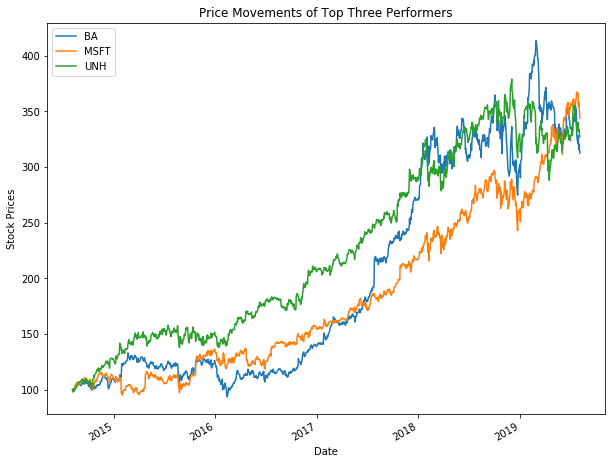

In [30]:
# Plot stock price movements over the past 5 years
(sec_data[top_performers]/sec_data[top_performers].iloc[0]*100).plot();
plt.ylabel('Stock Prices');
plt.title('Price Movements of Top Three Performers');

In [31]:
# Set the number of assets to assign weights
num_assets = 3

# Set the number of runs of random portfolio weights
num_portfolios = 1000

# Set up array to hold results
results = np.zeros((num_assets,num_portfolios))
results

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
#Generate the random weights for each company 
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights,sum(weights)

(array([0.35226511, 0.54491812, 0.10281677]), 1.0)

In [36]:
top_returns.mean()

pandas.core.series.Series

In [38]:
# Test the calculation of portfolio returns with random weights 
top_returns.mean()*250*weights

BA      0.079793
MSFT    0.133737
UNH     0.024218
dtype: float64

In [39]:
# Expected Portfolio Return
np.sum(weights*top_returns.mean()*250)

0.237747433405155

In [42]:
# Expected Portfolio Volatility
np.sqrt(np.dot(weights.T,np.dot(top_returns.cov()*250, weights)))

0.1928033663084819

In [45]:
import copy

pfolio_returns = []
pfolio_volatilities = []

min = float("inf")
min_weights = []

for x in range (num_portfolios):
    
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns = np.sum(weights * top_returns.mean()) * 250
    pfolio_volatilities = np.sqrt(np.dot(weights.T,np.dot(top_returns.cov() * 250, weights)))
    
    if pfolio_volatilities < min:
        min_weights = copy.deepcopy(weights)
        
    # Store results in results array
    results[0,x] = pfolio_returns
    results[1,x] = pfolio_volatilities
    # Store Sharpe Ratio(return/volatility) - risk free rate 
    results[2,x] = (results[0,x]- rf)/results[1,x]
    
print (min_weights)    
# convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns =['Return','Volatility','Sharpe'])

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['Volatility'].idxmin()]

[0.74423288 0.20216428 0.05360283]


In [44]:
results_frame.Return.max()

0.24522189726504118

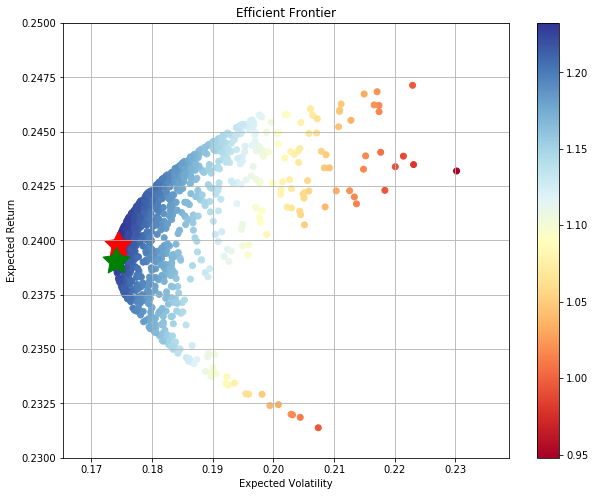

In [79]:
# # Visualize the effecient froniter from 1000 times simulations 
plt.scatter(results_frame.Volatility,results_frame.Return,c=results_frame.Sharpe,cmap='RdYlBu')
plt.colorbar()
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.ylim((0.23,0.25)) 
plt.grid(True)

#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=800)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=800)

plt.show()

### Insights: 
Markowitz proved the existence of an efficient set of portfolios that opimize investors' return for the aount of risk they are willing to accept. 

Here, I constructed the efficient froniter by building a promising portfolio of three stocks with highest expected returns. I labeled the minimum variance portfolio with green for the investors who want to optimize the portfolio return without assuming additional risk. 

The portfolio with highest Sharpe Ratio labeled as a red start, is intended for investors who want to pursue the highest return for a given amout of risk. Sharpe ratio is a great way to make a proper compaison beween stocks and portfolios and decide which one is preferable interms of risk and returns.


## Section V: Regression Analysis on the Correlation Between the Minimum Variance Portfolio and S&P 500 Index

In [80]:
min_port_returns = np.sum(min_weights * top_returns)
market_data = wb.DataReader(['^DJI','^GSPC'],data_source='yahoo',start=start,end=end)['Adj Close']

In [81]:
top_returns = min_weights*top_returns
top_returns['Total']=top_returns['BA'] + top_returns['MSFT'] + top_returns['UNH']

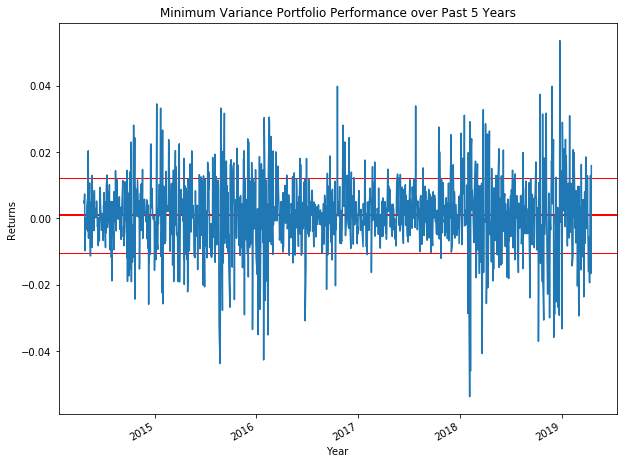

In [82]:
#Plot the portfolio performance over the past 5 years

graph = top_returns['Total'].plot();
plt.ylabel('Returns');
plt.xlabel('Year')
plt.title('Minimum Variance Portfolio Performance over Past 5 Years');

graph.axhline(y=top_returns['Total'].mean(),c="red",linewidth=2,zorder=0);
graph.axhline(y=top_returns['Total'].mean()+top_returns['Total'].std(),c="red",linewidth=1,zorder=0);
graph.axhline(y=top_returns['Total'].mean()-top_returns['Total'].std(),c="red",linewidth=1,zorder=0);

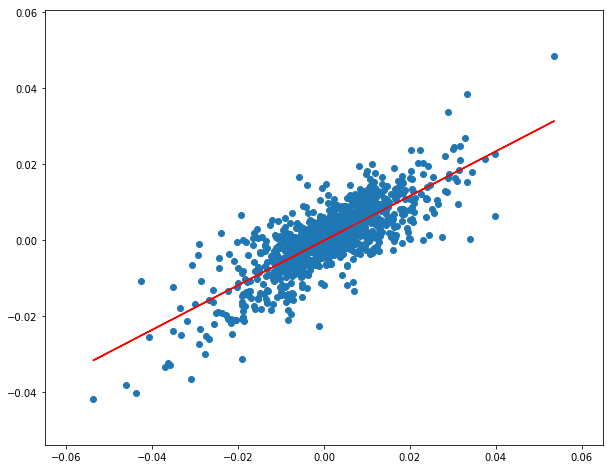

In [83]:
#Draw the scatter plot with minimum variance portfolio returns as an independent variable and SP500 market index as a dependent variable

X1 = top_returns['Total'][1:]
Y1 = log_returns['^GSPC'][1:]
plt.scatter(X1,Y1);

#Draw the trend line
z = np.polyfit(X1,Y1,1)
p = np.poly1d(z)
plt.plot(X1,p(X1),"r")
plt.show();

In [43]:
#Apply statsmodel to run regression and conclude detailed stats
x_hat = sm.add_constant(X1)
reg = sm.OLS(Y1, x_hat).fit()

In [44]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     2405.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):          4.37e-294
Time:                        17:24:02   Log-Likelihood:                 4908.2
No. Observations:                1258   AIC:                            -9812.
Df Residuals:                    1256   BIC:                            -9802.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.357      0.175      -0.000    8.37e-05
Total          0.5667      0.012     49.045      0.000       0.544       0.589
==============================================================================
Omnibus:                      143.002   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              938.221
Skew:                          -0.285   Prob(JB):                    1.85e-204
Kurtosis:                       7.192   Cond. No.                         83.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
comparison = {'Minimum Portfoilo Returns':[top_returns['Total'].mean()*250], 'S&P 500 Returns':[log_returns['^GSPC'].mean()*250]}
comparison = pd.DataFrame(comparison)
comparison.style.format({
    'Minimum Portfoilo Returns': '{:,.2%}'.format,
    'S&P 500 Returns': '{:,.2%}'.format,
})

,Minimum Portfoilo Returns,S&P 500 Returns
0,23.70%,8.73%


## Section VI:Conclude Insights from Previous Analysis

1. From the regression above, 69.9% of the portfolio returns is explained by the S&P 500 returns. Portfolio performance is generally aligned with the market. 
2. By comparing the average returns over the past 5 years, the minimum variance portfolio has achieven 24.27% returns by overperforming the market by a factor of 1.5.

## Section VII: Additional Analysis on Coorelation between Google Trends and Stock Returns

In [84]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ['Boeing','Software','Healthcare']

In [85]:
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

kw_searches = pytrends.interest_over_time()
kw_searches = kw_searches.iloc[1:]
kw_searches

,Boeing,Software,Healthcare,isPartial
date,,,,
2014-04-27,6,93,15,False
2014-05-04,6,93,15,False
2014-05-11,5,93,15,False
2014-05-18,6,94,15,False
2014-05-25,5,92,14,False
2014-06-01,6,91,15,False
2014-06-08,6,89,15,False
2014-06-15,5,92,15,False
2014-06-22,5,91,14,False


In [88]:
top_prices_weekly = sec_data[['BA','MSFT','V']].resample('W').mean()
top_prices_weekly = top_prices_weekly.iloc[1:-1]
top_prices_weekly['Searches'] = kw_searches['Boeing'] + kw_searches['Software'] + kw_searches['Healthcare']
top_prices_weekly['Total'] = top_prices_weekly['BA']+top_prices_weekly['MSFT']+top_prices_weekly['V']

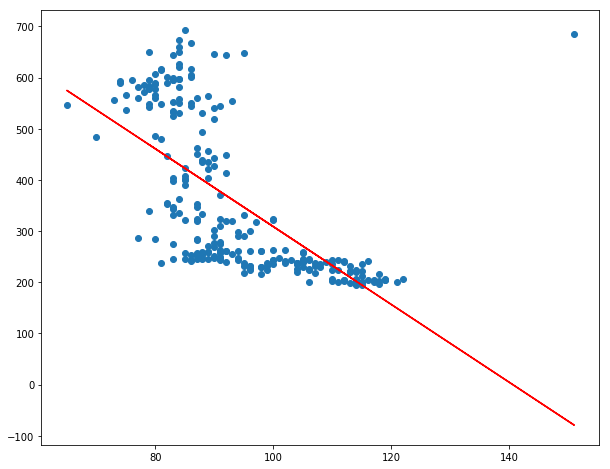

In [89]:
X1 = top_prices_weekly['Searches']
Y1 = top_prices_weekly['Total']
plt.scatter(X1,Y1);

#Draw the trend line
z = np.polyfit(X1,Y1,1)
p = np.poly1d(z)
plt.plot(X1,p(X1),"r")
plt.show();

In [91]:
#Apply statsmodel to run regression and conclude detailed stats
x_hat = sm.add_constant(X1)
reg = sm.OLS(Y1, x_hat).fit()

In [92]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     175.9
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           6.18e-31
Time:                        17:42:45   Log-Likelihood:                -1600.1
No. Observations:                 259   AIC:                             3204.
Df Residuals:                     257   BIC:                             3211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1069.2481     54.390     19.659      0.000     962.141    1176.355
Searches      -7.6034      0.573    -13.262      0.000      -8.732      -6.474
==============================================================================
Omnibus:                       94.604   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              465.229
Skew:                           1.398   Prob(JB):                    9.48e-102
Kurtosis:                       8.941   Cond. No.                         709.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""